# Example 3a: Triple junction cell

In the previous examples, we have considered only single-junction cells. However, a major part of Solcore's capability
lies in modelling multi-junction solar cells. In this example, we will look at a triple junction InGaP/GaAs/Ge cell at
1 Sun and under concentration.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from solcore import siUnits, material, si
from solcore.solar_cell import SolarCell
from solcore.structure import Junction, Layer
from solcore.solar_cell_solver import solar_cell_solver
from solcore.light_source import LightSource
from solcore.absorption_calculator import search_db

wl = np.linspace(300, 1850, 700) * 1e-9

We define our light source, the AM1.5G spectrum, which will be used for I-V calculations (not under concentration):

In [2]:
light_source = LightSource(source_type='standard', x=wl, version='AM1.5g')

Now we need to build the solar cell layer by layer.

*Note*: you need to have downloaded the refractiveindex.info database for these to work. See [Example 2a](2a-optical_constants.ipynb).

In [3]:
MgF2_pageid = search_db("MgF2/Rodriguez-de Marcos")[0][0]
ZnS_pageid = search_db("ZnS/Querry")[0][0]
MgF2 = material(str(MgF2_pageid), nk_db=True)()
ZnS = material(str(ZnS_pageid), nk_db=True)()

Database file found at /Users/phoebe/.solcore/nk/nk.db
1 results found.
pageid	shelf	book	page	filepath	hasrefractive	hasextinction	rangeMin	rangeMax	points
234	main	MgF2	Rodriguez-de_Marcos	main/MgF2/Rodriguez-de Marcos.yml	1	1	0.0299919	2.00146	960
Database file found at /Users/phoebe/.solcore/nk/nk.db
1 results found.
pageid	shelf	book	page	filepath	hasrefractive	hasextinction	rangeMin	rangeMax	points
623	main	ZnS	Querry	main/ZnS/Querry.yml	1	1	0.22	166.6667	312


To minimize front surface reflection, we use a four-layer anti-reflection coating (ARC):

In [4]:
ARC = [Layer(si("100nm"), MgF2), Layer(si("15nm"), ZnS), Layer(si("15nm"), MgF2), Layer(si("50nm"), ZnS)]

## Top cell: GaInP

Now we build the top cell, which requires the n and p sides of GaInP and a window layer. We also add some extra parameters needed for the calculation which are not included in the materials database, such as the minority carriers diffusion lengths.

In [5]:
AlInP = material("AlInP")
InGaP = material("GaInP")
window_material = AlInP(Al=0.52)

top_cell_n_material = InGaP(In=0.49, Nd=siUnits(2e18, "cm-3"), hole_diffusion_length=si("200nm"))
top_cell_p_material = InGaP(In=0.49, Na=siUnits(1e17, "cm-3"), electron_diffusion_length=si("1um"))

## Middle cell: GaAs

In [6]:
GaAs = material("GaAs")

mid_cell_n_material = GaAs(Nd=siUnits(3e18, "cm-3"), hole_diffusion_length=si("500nm"))
mid_cell_p_material = GaAs(Na=siUnits(1e17, "cm-3"), electron_diffusion_length=si("5um"))

## Bottom cell: Ge

In [7]:
Ge = material("Ge")

bot_cell_n_material = Ge(Nd=siUnits(2e18, "cm-3"), hole_diffusion_length=si("800nm"), hole_mobility=0.01)
bot_cell_p_material = Ge(Na=siUnits(1e17, "cm-3"), electron_diffusion_length=si("50um"), electron_mobility=0.1)

## Putting the cell together
And, finally, we put everything together, adding also the surface recombination velocities. We also add some shading due to the metallisation of the cell = 5%, and a finite series resistance.

In [8]:
solar_cell = SolarCell(
    ARC +
    [
        Junction([Layer(si("20nm"), material=window_material, role='window'),
                  Layer(si("100nm"), material=top_cell_n_material, role='emitter'),
                  Layer(si("560nm"), material=top_cell_p_material, role='base'),
                  ], sn=1, sp=1, kind='DA'),
        Junction([Layer(si("200nm"), material=mid_cell_n_material, role='emitter'),
                  Layer(si("3000nm"), material=mid_cell_p_material, role='base'),
                  ], sn=1, sp=1, kind='DA'),
        Junction([Layer(si("400nm"), material=bot_cell_n_material, role='emitter'),
                  Layer(si("100um"), material=bot_cell_p_material, role='base'),
                  ], sn=1, sp=1, kind='DA'),
    ], shading=0.05, R_series=2e-6)

## Setting the depth spacing

The 'position' option determines at which z-points the absorption profile is calculated. You can specify this is multiple different ways:

- a vector which specifies each position (in m) at which the depth should be calculated
- a single number which specifies the spacing (in m) to generate the position vector, e.g. 1e-9 for 1 nm spacing
- a list of numbers which specify the spacing (in m) to be used in each layer. This list can have EITHER the length of the number of individual layers + the number of junctions in the cell object, OR the length of the total number of individual layers including layers inside junctions.

Here we use the final options, setting the spacing to use per junction/layer. We use 0.1 nm for all layers except the final layer, the Ge, where we use 10 nm.

In [9]:
position = len(solar_cell) * [0.1e-9]
position[-1] = 10e-9
# Indexing with -1 in a Python list/array gives you the last element

Calculate and plot the EQE.

**PLOT 1**: EQE of a triple junction cell, comparing TMM and BL optical methods

Solving optics of the solar cell...
Treating layer(s) 10 incoherently
Calculating RAT...
Database file found at /Users/phoebe/.solcore/nk/nk.db
Material main/MgF2/Rodriguez-de Marcos.yml loaded.
Database file found at /Users/phoebe/.solcore/nk/nk.db
Material main/MgF2/Rodriguez-de Marcos.yml loaded.
Database file found at /Users/phoebe/.solcore/nk/nk.db
Material main/ZnS/Querry.yml loaded.
Database file found at /Users/phoebe/.solcore/nk/nk.db
Material main/ZnS/Querry.yml loaded.
Calculating absorption profile...
Solving QE of the solar cell...


/Users/phoebe/Documents/develop/solcore5/solcore/analytic_solar_cells/depletion_approximation.py:617: RuntimeWarning: invalid value encountered in true_divide
  iqe =  j_sc / current_absorbed


Solving optics of the solar cell...
Solving QE of the solar cell...


/Users/phoebe/Documents/develop/solcore5/solcore/analytic_solar_cells/depletion_approximation.py:617: RuntimeWarning: invalid value encountered in true_divide
  iqe =  j_sc / current_absorbed


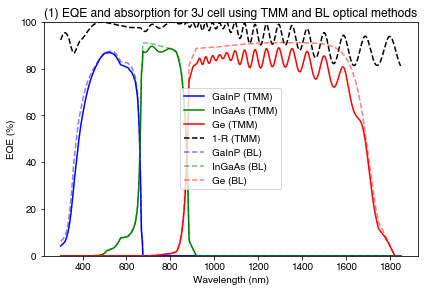

In [10]:
plt.figure()

solar_cell_solver(solar_cell, 'qe', user_options={'wavelength': wl, 'optics_method': "TMM",
                                                  'position': position, 'recalculate_absorption': True})

plt.plot(wl * 1e9, solar_cell[4].eqe(wl) * 100, 'b', label='GaInP (TMM)')
plt.plot(wl * 1e9, solar_cell[5].eqe(wl) * 100, 'g', label='InGaAs (TMM)')
plt.plot(wl * 1e9, solar_cell[6].eqe(wl) * 100, 'r', label='Ge (TMM)')
plt.plot(wl * 1e9, 100 * (1 - solar_cell.reflected), 'k--', label='1-R (TMM)')

solar_cell_solver(solar_cell, 'qe', user_options={'wavelength': wl, 'optics_method': "BL",
                                                  'position': position, 'recalculate_absorption': True})

plt.plot(wl * 1e9, solar_cell[4].eqe(wl) * 100, 'b--', alpha=0.5, label='GaInP (BL)')
plt.plot(wl * 1e9, solar_cell[5].eqe(wl) * 100, 'g--', alpha=0.5, label='InGaAs (BL)')
plt.plot(wl * 1e9, solar_cell[6].eqe(wl) * 100, 'r--', alpha=0.5, label='Ge (BL)')
plt.legend()
plt.ylim(0, 100)
plt.ylabel('EQE (%)')
plt.xlabel('Wavelength (nm)')
plt.tight_layout()
plt.title("(1) EQE and absorption for 3J cell using TMM and BL optical methods")
plt.show()

We see that the BL absorption is higher everywhere, because it does not include any front-surface reflection.
In the TMM calculation, we see interference fringes and some front-surface reflection (though due to the ARC, the
reflection is quite low).

Calculate and plot the light IV under the AM1.5G spectrum.

**PLOT 2**: Light IV for triple-junction cell

Solving optics of the solar cell...
Already calculated reflection, transmission and absorption profile - not recalculating. Set recalculate_absorption to True in the options if you want absorption to be calculated again.
Solving IV of the junctions...
Solving IV of the tunnel junctions...
Solving IV of the total solar cell...


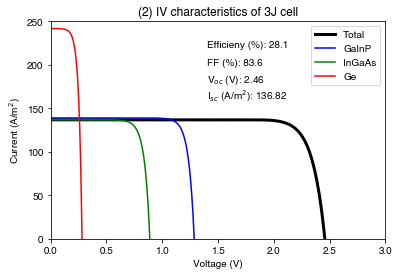

In [11]:
V = np.linspace(0, 3, 300)
solar_cell_solver(solar_cell, 'iv', user_options={'voltages': V, 'light_iv': True,
                                                  'wavelength': wl, 'mpp': True,
                                                  'light_source': light_source})

plt.figure()
plt.plot(V, solar_cell.iv['IV'][1], 'k', linewidth=3, label='Total')
plt.plot(V, -solar_cell[4].iv(V), 'b', label='GaInP')
plt.plot(V, -solar_cell[5].iv(V), 'g', label='InGaAs')
plt.plot(V, -solar_cell[6].iv(V), 'r', label='Ge')
plt.text(1.4, 220, 'Efficieny (%): ' + str(np.round(solar_cell.iv['Eta'] * 100, 1)))
plt.text(1.4, 200, 'FF (%): ' + str(np.round(solar_cell.iv['FF'] * 100, 1)))
plt.text(1.4, 180, r'V$_{oc}$ (V): ' + str(np.round(solar_cell.iv["Voc"], 2)))
plt.text(1.4, 160, r'I$_{sc}$ (A/m$^2$): ' + str(np.round(solar_cell.iv["Isc"], 2)))

plt.legend()
plt.ylim(0, 250)
plt.xlim(0, 3)
plt.ylabel('Current (A/m$^2$)')
plt.xlabel('Voltage (V)')
plt.title("(2) IV characteristics of 3J cell")

plt.show()

## Cell behaviour under concentration

Multi-junction cells are often used in concetrator PV applications. Here, we look at the effect of increasing the
concentration on the Voc, Jsc and the efficiency.

Concentration between 1x and 3000x, linearly spaced on a log scale:

In [12]:
concentration = np.linspace(np.log(1), np.log(3000), 20)
concentration = np.exp(concentration)

Create empty arrays to store the data (this is preferable to simply appending data in a loop since it pre-allocates the memory needed to store the arrays):

In [13]:
Effs = np.empty_like(concentration)
Vocs = np.empty_like(concentration)
Iscs = np.empty_like(concentration)

V = np.linspace(0, 3.5, 300)

Loop through the concentrations. We use only the direct spectrum (AM1.5D) since diffuse light will not be concentrated:

In [14]:
for i1, conc in enumerate(concentration):

    # We make a light source with the concentration being considered. We also use AM1.5D (direct only) rather than AM1.5G
    # (direct + diffuse):
    light_conc = LightSource(source_type='standard', x=wl, version='AM1.5d', concentration=conc)

    solar_cell_solver(solar_cell, 'iv', user_options={'voltages': V, 'light_iv': True,
                                                      'wavelength': wl, 'mpp': True,
                                                      'light_source': light_conc})

    # Save the calculated values in the arrays:
    Effs[i1] = solar_cell.iv["Eta"] * 100
    Vocs[i1] = solar_cell.iv["Voc"]
    Iscs[i1] = solar_cell.iv["Isc"]


Solving optics of the solar cell...
Already calculated reflection, transmission and absorption profile - not recalculating. Set recalculate_absorption to True in the options if you want absorption to be calculated again.
Solving IV of the junctions...
Solving IV of the tunnel junctions...
Solving IV of the total solar cell...
Solving optics of the solar cell...
Already calculated reflection, transmission and absorption profile - not recalculating. Set recalculate_absorption to True in the options if you want absorption to be calculated again.
Solving IV of the junctions...
Solving IV of the tunnel junctions...
Solving IV of the total solar cell...
Solving optics of the solar cell...
Already calculated reflection, transmission and absorption profile - not recalculating. Set recalculate_absorption to True in the options if you want absorption to be calculated again.
Solving IV of the junctions...
Solving IV of the tunnel junctions...
Solving IV of the total solar cell...
Solving optics o

**PLOT 3**: Efficiency, open-circuit voltage and short-circuit current at different concentrations for the 3J cell

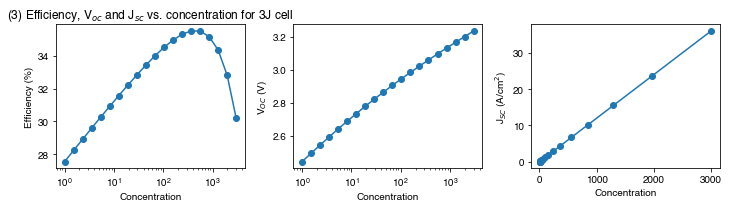

In [15]:
plt.figure(figsize=(10, 3))
plt.subplot(131)
plt.semilogx(concentration, Effs, '-o')
plt.ylabel('Efficiency (%)')
plt.xlabel('Concentration')
plt.title("(3) Efficiency, V$_{oc}$ and J$_{sc}$ vs. concentration for 3J cell")

plt.subplot(132)
plt.semilogx(concentration, Vocs, '-o')
plt.ylabel(r'V$_{OC}$ (V)')
plt.xlabel('Concentration')

plt.subplot(133)
plt.plot(concentration, Iscs / 10000, '-o')
plt.ylabel(r'J$_{SC}$ (A/cm$^2$)')
plt.xlabel('Concentration')
plt.tight_layout()
plt.show()